# Simple neural network from scratch

in this notebook we will:
- define a simple neural network in the JAX library
- define a loss function to measure its performance
- perform a simple stochastic gradient descent to optimise the network parameters by minimising the loss function

In [90]:
import jax # The main library we'll be using here
import jax.numpy as np # The entire numpy library, but differentiable
import jax.random as jr
import einops # Fancy reshaping of arrays
from tqdm.notebook import tqdm # Loading bars for our loops
import matplotlib.pyplot as plt # Visualisation


### We load the mnist handwritten digit dataset:
- x_train: (60000,28,28) array of images (28*28 resolution)
- x_test: (10000,28,28) array of images (28*28 resolution)

- y_train: (60000) array of labels (integers 0-9)
- y_test: (10000) array of labels (integers 0-9)

- y_train_1hot: (60000,10) array of one hot encoded labels
- y_test_1hot: (10000,10) array of one hot encoded labels

We should always visualise what our data actually looks like


In [91]:
# We only use tensorflow for loading the mnist dataset 
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train_flat = einops.rearrange(x_train,"batches w h -> batches (w h)") / 255.0
x_test_flat = einops.rearrange(x_test,"batches w h -> batches (w h)") / 255.0
y_train_1hot = jax.nn.one_hot(y_train,num_classes=10,axis=-1)
y_test_1hot = jax.nn.one_hot(y_test,num_classes=10,axis=-1)


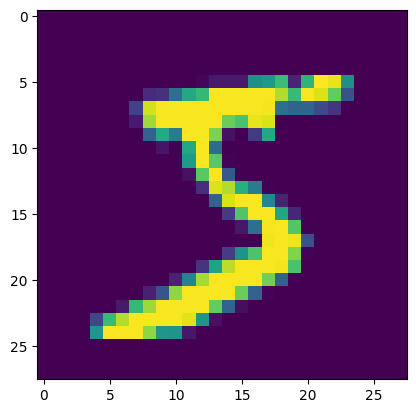

In [94]:
plt.imshow(x_train[0])
plt.show()

## Introduction to Jax 
- JAX is a python library that essentially reproduces numpy, but with 3 very useful additions:
    - everything is automatically differentiable
    - code automatically parallelises to GPUs (when applicable)
    - code can be Just In Time (JIT) compiled to run much faster than python typically does
- the `jax.numpy` module has the same API as numpy, so if you replace `import numpy as np` with `import jax.numpy as np` your code will probably work
- All random methods in JAX require a PRNGKey object passed into them
- This is to avoid side effects, keeping functions that rely on random numbers pure

In [95]:
SEED = 1234
key = jr.PRNGKey(SEED)

In [117]:
def _f(x,y):
    return (x-y)**2
df = jax.grad(_f)
print(df(5.0,2.0))

6.0


### Linear fully connected layers:
- The linear layers of a fully connected feed-forward neural network (or multi-layer-perceptron) are just matrix multiplications followed by adding a bias vector

In [96]:
def linear_layer(x,weights,bias):
    return np.matmul(weights,x) + bias


### Lets define some nonlinear activation functions:
- relu (REctified Linear Unit) just sets negative values to 0. It's fast to compute and works fairly well
- softmax normalises the output to be a probability distribution

In [6]:
def relu_activation(x):
    return np.maximum(x,0)

def softmax_activation(x):
    Z = np.sum(np.exp(x))
    return np.exp(x)/Z

### Now define a neural network as a python class:
 - `__init__` method defines the sizes of input, hidden and output layers
 - `__call__` allows for objects of this class to be called like functions
 - multiplying the normally distributed parameters by `0.01` in `__init__` is important
    - if initial random parameters are too large, training tends to diverge to NaN

In [97]:
class SimpleNetwork(object):
    def __init__(self,input_size,hidden_size,output_size,key):
        key1,key2,key3,key4 = jr.split(key,4) # PRNGKey used to initialise model parameters
        self.weights = [jr.normal(key1,shape=(hidden_size,input_size))*0.01,
                        jr.normal(key2,shape=(output_size,hidden_size))*0.01]
        self.bias = [jr.normal(key3,shape=(hidden_size,))*0.01,
                     jr.normal(key4,shape=(output_size,))*0.01]
        
        
    def __call__(self,x):
        
        h1 = linear_layer(x,self.weights[0],self.bias[0])
        h2 = relu_activation(h1)
        h3 = linear_layer(h2,self.weights[1],self.bias[1])
        h4 = softmax_activation(h3)
        return h4

In [103]:
nn = SimpleNetwork(784,100,10,key)
print(nn(x_train_flat[4]))


[0.10191788 0.10068461 0.10017712 0.09966286 0.09672046 0.10055019
 0.10191927 0.09926675 0.1001219  0.09897896]


### Now define a loss function - this is the bit with the gradient:
- `loss` takes as input model_parameters, model, x and y, where:
    - model_parameters: is a list of arrays representing the weights and biasses
    - model: callable (model_parameters,x)->y is the neural network function itself
    - x: array [BATCHES,784] is the input data
    - y: array [BATCHES,10] is the correct outputs to compare to
- loss returns a scalar, think of this as a measure of how wrong the model is
- the `@jax.value_and_grad` wrapper means that loss returns both it's normal output, and the gradient of this output __with respect to it's first input__ (model_parameters)

- the `jax.vmap` vectorises the model function - so it works on [BATCHES,748] inputs rather than just [748] inputs

In [106]:
@jax.value_and_grad
def loss(model_params,model,x,y):
    """Loss function

    Args:
        model_parameters (list of arrays): parameters of the network model
        model (callable (model_parameters,x)->y ): neural network model being trained
        x (array [BATCHES,1,28,28]): image of number
        y (array [BATCHES,10]): one hot encoding of number label

    Returns:
        float: loss - zero when y_pred=y, higher otherwise
    """
    model.weights = [model_params[0],model_params[1]]
    model.bias = [model_params[2],model_params[3]]
    
    y_predicted = jax.vmap(model,in_axes=0,out_axes=0,axis_name="BATCHES")(x)

    #print(y_predicted)
    #return np.mean((y_predicted-y)**2)
    return -np.mean(y*np.log(y_predicted))

### Now we define an optimiser:
- This is just a function that updates the model parameters based on the loss gradients
- To minimise the loss we use a 1st order gradient descent:
    -  $\theta_{i+1} = \theta_i - h\nabla_\theta L(\theta,x,y)$
    - where $h$ is the `learn_rate`

In [79]:
def optimiser(model_parameters,gradient,learn_rate):
    # Simple gradient descent step
    for i,dm in enumerate(gradient):
        model_parameters[i] -= learn_rate*dm
    return model_parameters

### Now we stick everything together:
- iteratively:
    - calculate loss gradients of the model
    - update the model parameters based on these gradients

In [109]:
# Set network and training log
key = jr.fold_in(key,1)
nn = SimpleNetwork(28*28,100,10,key)
nn_params = [nn.weights[0],nn.weights[1],nn.bias[0],nn.bias[1]]
TRAIN_ITERS = 1000
BATCH_SIZE = 64
loss_log = []


for i in tqdm(range(TRAIN_ITERS)):
    
    # Randomly choose 32 pairs of X and Y
    train_key = jr.fold_in(key,i)
    inds = jr.choice(train_key,np.arange(60000),(BATCH_SIZE,),replace=False)
    x = x_train_flat[inds]
    y = y_train_1hot[inds]
    
    loss_value,grad = loss(nn_params,nn,x,y) # Compute loss
    nn_params = optimiser(nn_params,grad,learn_rate=1e-1) # Apply gradient updates to model parameters
    
    
    loss_log.append(loss_value) # Record current loss
    if i%10==0:
        tqdm.write("Loss at step "+str(i)+": "+str(loss_value)) # Print loss to screen during training
    

  0%|          | 0/1000 [00:00<?, ?it/s]

Loss at step 0: 0.23024169
Loss at step 10: 0.23002706
Loss at step 20: 0.23018269
Loss at step 30: 0.22991692
Loss at step 40: 0.22967152
Loss at step 50: 0.22959352
Loss at step 60: 0.22937684
Loss at step 70: 0.2297097
Loss at step 80: 0.22920239
Loss at step 90: 0.22949259
Loss at step 100: 0.22919722
Loss at step 110: 0.22926047
Loss at step 120: 0.22908269
Loss at step 130: 0.22856322
Loss at step 140: 0.22891536
Loss at step 150: 0.22821684
Loss at step 160: 0.22843042
Loss at step 170: 0.22782283
Loss at step 180: 0.22803254
Loss at step 190: 0.22753358
Loss at step 200: 0.22786732
Loss at step 210: 0.22724234
Loss at step 220: 0.22662273
Loss at step 230: 0.22684613
Loss at step 240: 0.22560708
Loss at step 250: 0.22458501
Loss at step 260: 0.22479062
Loss at step 270: 0.22456923
Loss at step 280: 0.22430158
Loss at step 290: 0.22370043
Loss at step 300: 0.22313046
Loss at step 310: 0.22226404
Loss at step 320: 0.22144471
Loss at step 330: 0.22141834
Loss at step 340: 0.221289

### Lets check how the model trained

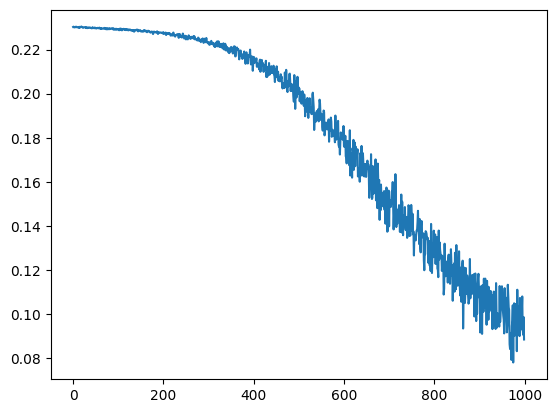

In [110]:
plt.plot(loss_log)

### Let's evaluate our trained model on the test dataset
- A confusion matrix is a useful way to visualise this
    - each entry $C_{ij}$ counts how many times an image of class $i$ was labelled as class $j$
    - If our model is perfect, this matrix should be diagonal
    - It can be helpful to understand if there are two classes of images that are often confused

In [ ]:
y_test_predictions = np.argmax(jax.vmap(nn)(x_test_flat),axis=1) # By taking the maximum of the output probability distribution, we are forcing the model to discretely choose a number
confusion_matrix = np.zeros((10,10))
for i in range(len(y_test)):
    confusion_matrix = confusion_matrix.at[y_test[i],y_test_predictions[i]].set(confusion_matrix[y_test[i],y_test_predictions[i]]+1)




In [ ]:
plt.imshow(confusion_matrix)

### What next?
- This model is pretty bad
- having to explictely pass around model parameters and model is annoying
- having to define our own optimiser is annoying
- How do we choose good hyper-paramters:
    - number of layers
    - sizes of layers
    - types of activation function
- Training sometimes hits NaN - dependant on random initialisation